# Project 1: House Price Prediction

# Introduction:

*   In this project, you will use various features of houses to predict their estimated value.
*   You will perform exploratory data analysis, data preprocessing, and apply multiple regression models to find the best one.
*   Finally, you will evaluate the performance of your models using common regression metrics.

**Datasets Locations and Names:** Canvas -> Modules -> Week 6 -> Datasets -> "House_Sales_Dataset.csv".

Please save your Googgle Colab project as FirstName_LastName_Project1.ipynb and submit (upload) your source code to Canvas.

# Dataset Description:

* id: Unique ID for each house.
* estimated_value: The price the house is predicted to sell for (target variable).
* living_units: The number of bedrooms in the house.
* baths: The number of bathrooms in the house.
* interior_size: The interior living space size in square feet.
* lot_size: The size of the lot in square feet.
* num_floors: The number of floors in the house.
* has_waterfront: Whether the house has a waterfront view.
* scenic_view: Whether the house has a scenic view.
* house_condition: The overall condition of the house, with higher values indicating better condition.
* year_built: The year the house was built.

# Task 1: Exploratory Data Analysis (EDA)
* Visualize the distribution of the target variable (`estimated_value`).
* Create scatter plots or histograms to explore relationships between features like `living_units`, `baths`, `interior_size`, and `estimated_value`.
* Use a correlation heatmap to observe correlations between features and `estimated_value`.

,estimated_value,interior_size,living_units,baths
estimated_value,1.000000,0.702035,0.308350,0.525138
interior_size,0.702035,1.000000,0.576671,0.754665
living_units,0.308350,0.576671,1.000000,0.515884
baths,0.525138,0.754665,0.515884,1.000000


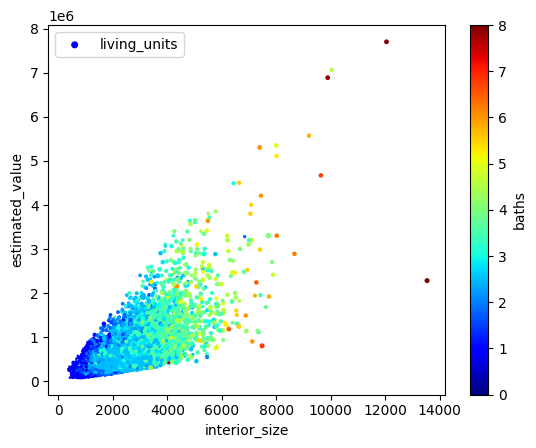

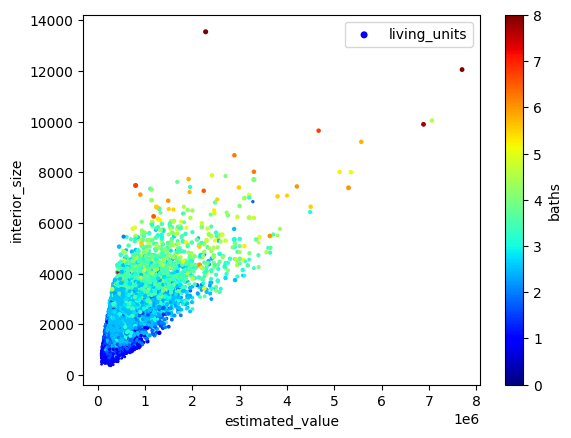

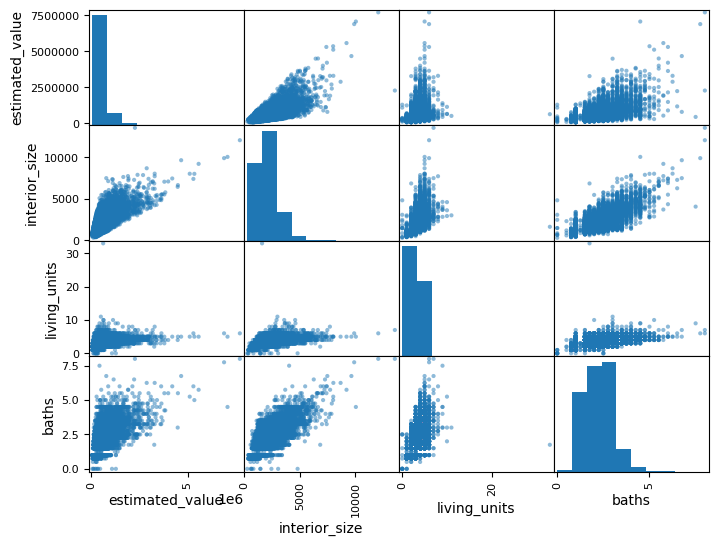

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

house = pd.read_csv("sample_data/House_Sales_Dataset.csv")

house.plot(kind='scatter', x='interior_size', y='estimated_value',
           s=house['living_units'], label='living_units',
           c='baths', cmap=plt.get_cmap('jet'),
           colorbar = True

           )

house.plot(kind='scatter', x='estimated_value', y='interior_size',
           s=house['living_units'], label='living_units',
           c='baths', cmap=plt.get_cmap('jet'),
           colorbar = True

           )


from pandas.plotting import scatter_matrix

features = ['estimated_value', 'interior_size', 'living_units', 'baths']
scatter_matrix(house[features], figsize=(8,6))

#correlation heatmap
corr = house[features].corr()
corr.style.background_gradient(cmap ='RdYlGn')

#corr_matrix = house.corr(numeric_only=True)
#corr_matrix['estimated_value'].sort_values(ascending=False)

# Task 2: Data Preprocessing with Pipelines and Feature Extraction
* Use Pipeline for handling missing values, scaling, and feature extraction.
* Use ColumnTransformer for applying different transformations to numeric and categorical features.

In [ ]:

#split data into training and testing data 80:20 ratio
def split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

train_data, test_data = split_data(house, 0.2)
#print(len(train_data))
#print(len(test_data))
train_data.head()

house['sqft_living_cat'] = pd.cut(house['sqft_living15'], bins=[0, 1000, 2000, 3000, 4000, np.inf]
                             , labels=[1,2,3,4,5])

house['baths_per_living_unit'] = house['baths'] / house['living_units']
house['value_per_sqft'] = house['estimated_value'] / (house['sqft_living15'] + house['sqft_lot15'])
house['lot_size_per_living_unit'] = house['lot_size'] / house['living_units']


#stratified shuffle my sqft living var
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=46)

for train_index, test_index in split.split(house, house['sqft_living_cat']):
  strat_train_set = house.iloc[train_index]
  strat_test_set = house.iloc[test_index]

strat_test_set['sqft_living_cat'].value_counts() / len(strat_test_set)

#remove the unused var from data set
strat_train_set.drop('sqft_living_cat', axis=1, inplace=True)
strat_test_set.drop('sqft_living_cat', axis=1, inplace=True)

#copy data set to prepare for transformations
housing = strat_train_set.copy()

#imputer

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

housing_num = housing.drop(["has_waterfront", "scenic_view", "date"], axis=1)

#removes infinite values that can't be converted to float64
housing_num_new = housing_num[np.isfinite(housing_num).all(1)]
imputer.fit(housing_num_new)

#drop the estimated value columns and prepare training labels
train = strat_train_set.drop('estimated_value', axis=1)
train_labels = strat_train_set['estimated_value'].copy()

test = strat_test_set.drop('estimated_value', axis=1)
test_labels = strat_test_set['estimated_value'].copy()

#split attributes to standard, maxmin, and category
num_std_attribs = ['id', 'living_units', 'baths', 'interior_size',
                   'lot_size', 'num_floors', 'house_condition', 'sqft_above',
                   'year_built', 'zipcode', 'sqft_living15', 'sqft_lot15'
                   ]

num_maxmin_attribs = ['long', 'lat']

cat_attribs = ['has_waterfront', 'scenic_view', 'date']


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

#pipelines
numeric_std_pipeline = Pipeline([
    ['imputer', SimpleImputer(strategy='median')],
                                 ['stdscalar', StandardScaler()]])

numeric_minmax_pipeline = Pipeline([
    ['imputer', SimpleImputer(strategy='median')],
                                 ['minmaxscaler', MinMaxScaler()]])

cat_pipeline = Pipeline([
  ('onehotencoder', OneHotEncoder(handle_unknown='ignore'))])

#column transformer
from sklearn.compose import ColumnTransformer

full_transformer = ColumnTransformer([('numeric_stdpreprocessing', numeric_std_pipeline, num_std_attribs),
                                      ('numeric_minmaxpreprocessing', numeric_minmax_pipeline, num_maxmin_attribs),
                                      ('cat_preprocessing', cat_pipeline, cat_attribs)
])


<ipython-input-6-de02bac9f53c>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_train_set.drop('sqft_living_cat', axis=1, inplace=True)
<ipython-input-6-de02bac9f53c>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strat_test_set.drop('sqft_living_cat', axis=1, inplace=True)


# Task 3: Train Regression Models
Train at least 5 regression models within a pipeline:
* Linear Regression
* Decision Tree
* Random Forest
* Ridge Regression
* Lasso Regression

In [ ]:
#Linear
from sklearn.linear_model import LinearRegression

p1_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
                             ('linear_regression', LinearRegression())
])


#Decision Tree
from sklearn.tree import DecisionTreeRegressor

p2_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
                             ('decision_tree_regression', DecisionTreeRegressor())
                             ])

#Random Forest
from sklearn.ensemble import RandomForestRegressor

p3_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
                             ('random_forest_regression', RandomForestRegressor(n_estimators=20,max_depth=10))
                             ])

#Ridge
from sklearn.linear_model import Ridge

p4_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
                             ('ridge_regression', Ridge())
                             ])

#Lasso
from sklearn.linear_model import Lasso

p5_full_pipeline = Pipeline([('all_column_transformation', full_transformer),
                             ('lasso_regression', Lasso())
                             ])

# Task 4: Hyperparameter Tuning with GridSearchCV
* Apply GridSearchCV to at least one model for hyperparameter tuning.

In [ ]:
#I am using GridSearchCV on my Ridge Regression Model
from sklearn.model_selection import GridSearchCV

grid_search_attribs = {
    'ridge_regression__alpha': [1, 10, 100]
}

# Initialize the grid search
grid_search_cv = GridSearchCV(p4_full_pipeline, grid_search_attribs, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search_cv.fit(train, train_labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('all_column_transformation',
                                        ColumnTransformer(transformers=[('numeric_stdpreprocessing',
                                                                         Pipeline(steps=[['imputer',
                                                                                          SimpleImputer(strategy='median')],
                                                                                         ['stdscalar',
                                                                                          StandardScaler()]]),
                                                                         ['id',
                                                                          'living_units',
                                                                          'baths',
                                                                          'interior_size',
                                                                          'lot_size',
                                                                          'num_floors',
                                                                          'house_condition',
                                                                          'sqft_above',
                                                                          'year_built',
                                                                          'zipcode',...
                                                                         Pipeline(steps=[['imputer',
                                                                                          SimpleImputer(strategy='median')],
                                                                                         ['minmaxscaler',
                                                                                          MinMaxScaler()]]),
                                                                         ['long',
                                                                          'lat']),
                                                                        ('cat_preprocessing',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['has_waterfront',
                                                                          'scenic_view',
                                                                          'date'])])),
                                       ('ridge_regression', Ridge())]),
             param_grid={'ridge_regression__alpha': [1, 10, 100]},
             scoring='neg_mean_squared_error')

# Task 5: Model Evaluation
* Evaluate the performance of each model using RMSE, MAE, and R-squared.
* Compare the models and discuss which performed best and why.

In [ ]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error

def fit_and_print(p, train_set, train_labels, test_set, test_labels):
  p.fit(train_set, train_labels)
  train_preds = p.predict(train_set)
  test_preds = p.predict(test_set)

  print("Training Error MAE:" + str(mean_absolute_error(train_preds, train_labels)))

  print("Test Error MAE:" + str(mean_absolute_error(test_preds, test_labels)))

  print("Training Error RMSE:" + str(root_mean_squared_error(train_preds, train_labels)))

  print("Test Error RMSE:" + str(root_mean_squared_error(test_preds, test_labels)))

  print("r2 Score:" + str(r2_score(test_preds, test_labels)))

print("Linear Regression Model")
fit_and_print(p1_full_pipeline, train, train_labels, test, test_labels)
print("")
print("Decision Tree Regression Model")
fit_and_print(p2_full_pipeline, train, train_labels, test, test_labels)
print("")
print("Random Forest Regression Model")
fit_and_print(p3_full_pipeline, train, train_labels, test, test_labels)
print("")
print("Ridge Regression Model")
fit_and_print(p4_full_pipeline, train, train_labels, test, test_labels)
print("")
print("Lasso Regression Model")
fit_and_print(p5_full_pipeline, train, train_labels, test, test_labels)
print("")
print("Analysis")
print("The linear, ridge, and lasso models all have similar R2 scores and performed okay.")
print("The decision Tree model had very seperate testing and training scores, so it's strongly overfitting.")
print("The random forest regression model has a high r2 and close test/training values, so it performed the best of the models.")

Linear Regression Model
Training Error MAE:131330.69627476443
Test Error MAE:136907.84034048955
Training Error RMSE:204231.37204799574
Test Error RMSE:223527.6912192652
r2 Score:0.48748869359466396

Decision Tree Regression Model
Training Error MAE:0.11839213418160786
Test Error MAE:102857.12676382142
Training Error RMSE:11.0079221170426
Test Error RMSE:220740.11592827222
r2 Score:0.6827689475301455

Random Forest Regression Model
Training Error MAE:64387.070706822946
Test Error MAE:81525.87234536519
Training Error RMSE:100841.30475825617
Test Error RMSE:156069.1688438236
r2 Score:0.8028657150775073

Ridge Regression Model
Training Error MAE:131438.99612607172
Test Error MAE:136464.9848670334
Training Error RMSE:204411.3878410308
Test Error RMSE:221550.5845985463
r2 Score:0.4922753297097985

Lasso Regression Model
Training Error MAE:131324.89769034862
Test Error MAE:136809.17336993568
Training Error RMSE:204233.0969174203
Test Error RMSE:223432.49482944875
r2 Score:0.48752228113234497


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 34469935455016.875, tolerance: 226529830589.4522
  model = cd_fast.sparse_enet_coordinate_descent(


# Conclusion:
* Summarize your findings and explain any interesting insights from your analysis.

My linear, ridge, and lasso regression models performed relatively similar to each other. They had training errors arround 130,000, and testing errors around 6,000 greater than the training. The models are underfitting, since even in training they have a large error.
My decision tree regression model is overfitting. This is shown by the extremely low training error and extremely high testing error in comparison.
Lastly, the random forest regression model had a high r2 score and training/testing data that was close to each other. It was the best performing model of the 5.

I've learned that GridSearchCV works well with less-complex models. I initially tried to use GridSearchCV for my RandomForest model, but after 18 minutes of compiling it still wasn't finished. This is what led me to transition to using GridSearch for the ridge model. I also applied some parameters to random forest to help it compile r2 and MAE faster. I lowered the number of estimators from the default 100 to 20, and capped the max depth at 10.